In [1]:
import torch
import os,sys
sys.path.append("..")

In [2]:
# --- Stage-0 : set paths & load raw arrays ----------------------------
from pathlib import Path
import numpy as np

DATA_DIR = Path(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw")          # change here if you move the .npy files

RAW_X_TRAIN = DATA_DIR / "xs_train.npy"
RAW_X_TEST  = DATA_DIR / "xs_test.npy"
RAW_Y_TRAIN = DATA_DIR / "ys_train.npy"
RAW_Y_TEST  = DATA_DIR / "ys_test.npy"

xs_train = np.load(RAW_X_TRAIN)           # (N_train, 192, 2)
xs_test  = np.load(RAW_X_TEST)            # (N_test , 192, 2)
ys_train = np.load(RAW_Y_TRAIN)           # (N_train, 2)  -> [CL, CD]
ys_test  = np.load(RAW_Y_TEST)            # (N_test , 2)

print("Train shapes :", xs_train.shape, ys_train.shape)
print("Test  shapes :", xs_test.shape , ys_test.shape)
# ----------------------------------------------------------------------


Train shapes : (38802, 192, 2) (38802, 2)
Test  shapes : (9701, 192, 2) (9701, 2)


# Models

In [3]:
import sys, os
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../.."))
sys.path.append("../surrogate_models")
import torch.nn as nn
import torch.nn.functional as F
import torch

activation_function_list = [torch.tanh, nn.ReLU(), nn.CELU(), nn.LeakyReLU(), nn.ELU(), nn.Hardswish(),torch.tanh, nn.ReLU(), nn.CELU(), nn.LeakyReLU(), torch.tanh]

class MultiLayerPerceptron_forward(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, net_n):
        super(MultiLayerPerceptron_forward, self).__init__()
        #################################################################################
        # Initialize the modules required to implement the mlp with given layer   #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        #################################################################################
        layers = []
        layers.append(nn.Linear((input_size), (hidden_layers[0])))
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear((hidden_layers[i]), (hidden_layers[i+1])))

        layers.append(nn.Linear((hidden_layers[len(hidden_layers)-1]), (num_classes)))
        self.layers = nn.Sequential(*layers)
        self.net_n = net_n
        self.hidden_layers = hidden_layers
    def forward(self, x):
        #################################################################################
        # Implement the forward pass computations                                 #
        #################################################################################
        m = activation_function_list[self.net_n]
        for i in range(len(self.hidden_layers)):
            x = self.layers[i](x)
            x = m(x)
        x = (self.layers[len(self.hidden_layers)](x))
        out=x
        return out

#===================================================    

import torch
import torch.nn as nn
import torch.nn.functional as F

# List of activation functions
activation_function_list = [
    torch.tanh, nn.ReLU(), nn.CELU(), nn.LeakyReLU(), nn.ELU(),
    nn.Hardswish(), torch.tanh, nn.ReLU(), nn.CELU(), nn.LeakyReLU(), torch.tanh
]

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim

        # Learnable linear projections
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key   = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.scale = embed_dim ** 0.5

    def forward(self, x):
        # x shape: (batch, seq_len, embed_dim)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Attention scores: (batch, seq_len, seq_len)
        scores = torch.bmm(Q, K.transpose(1, 2)) / self.scale
        attn_weights = F.softmax(scores, dim=-1)

        # Weighted sum: (batch, seq_len, embed_dim)
        attn_output = torch.bmm(attn_weights, V)
        return attn_output


class MultiLayerPerceptronWithCustomAttention(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, net_n):
        super(MultiLayerPerceptronWithCustomAttention, self).__init__()

        # MLP Layers
        layers = []
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        self.mlp_layers = nn.ModuleList(layers)
        self.activation = activation_function_list[net_n]
        
        self.attention = SelfAttention(embed_dim=hidden_layers[-1])
        self.final_linear = nn.Linear(hidden_layers[-1], num_classes)

    def forward(self, x):
        # MLP forward
        for layer in self.mlp_layers:
            x = self.activation(layer(x))

        # Reshape for attention: treat features as a sequence of length 1
        x = x.unsqueeze(1)  # (batch, 1, embed_dim)

        # Apply attention
        x = self.attention(x)

        # Flatten back to (batch, embed_dim)
        x = x.squeeze(1)

        # Final output
        out = self.final_linear(x)
        return out

#====================================================

class ResidualBlock1D(nn.Module):
    """
    A 1D residual block with optional downsampling.
    The first conv can do stride=2 if downsample=True, the second conv uses stride=1.
    We'll use kernel=5, pad=2 so that stride=1 doesn't reduce length at all.
    """
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        self.downsample = downsample

        # If we want to downsample, we set stride=2 for the first conv and the shortcut
        stride_first = 2 if downsample else 1
        kernel_size = 5
        pad = 2

        # 1) First conv
        self.bn1 = nn.BatchNorm1d(in_channels, momentum=0.9)
        self.conv1 = nn.Conv1d(in_channels, out_channels,
                               kernel_size=kernel_size,
                               stride=stride_first,
                               padding=pad)
        # 2) Second conv always stride=1
        self.bn2 = nn.BatchNorm1d(out_channels, momentum=0.9)
        self.conv2 = nn.Conv1d(out_channels, out_channels,
                               kernel_size=kernel_size,
                               stride=1,
                               padding=pad)

        # Shortcut (for downsample or channel mismatch)
        if downsample or (in_channels != out_channels):
            self.shortcut_conv = nn.Conv1d(in_channels, out_channels,
                                           kernel_size=1,
                                           stride=stride_first,
                                           padding=0)
        else:
            self.shortcut_conv = nn.Identity()

        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x, debug=False):
        if debug:
            print(f"  [ResidualBlock] Input shape: {x.shape}")
        identity = self.shortcut_conv(x)     # Possibly stride=2 if downsample is True

        # First conv
        out = self.bn1(x)
        out = self.lrelu(out)
        out = self.conv1(out)
        if debug:
            print(f"    After conv1 shape: {out.shape}")

        # Second conv
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)
        if debug:
            print(f"    After conv2 shape: {out.shape}")

        # Add skip
        out = out + identity
        if debug:
            print(f"  [ResidualBlock] Output shape: {out.shape}\n")

        return out


class SurrogateModel1D(nn.Module):
    """
    A 1D ResNet-like approach for (batch, 2, n_points).
    We'll do four "groups" of blocks, each of which can downsample the length dimension in the first block.
    """
    def __init__(self, n_points=192, in_channels=2, depth=16, residual_list=[2,2,2,2]):
        super().__init__()
        self.depth = depth
        self.residual_list = residual_list

        # -- Initial Conv: kernel=5, pad=2, stride=1 => length stays 192
        self.conv_initial = nn.Conv1d(in_channels, depth, kernel_size=5, stride=1, padding=2)
        self.bn_initial = nn.BatchNorm1d(depth, momentum=0.9)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

        # Group0: no downsample in first block
        self.blocks0 = nn.ModuleList([
            ResidualBlock1D(depth, depth, downsample=False)
            for _ in range(residual_list[0])
        ])
        # Group1: first block downsample => depth-> depth*2
        self.resblock1_0 = ResidualBlock1D(depth, depth*2, downsample=True)
        self.blocks1 = nn.ModuleList([
            ResidualBlock1D(depth*2, depth*2, downsample=False)
            for _ in range(residual_list[1]-1)
        ])
        # Group2
        self.resblock2_0 = ResidualBlock1D(depth*2, depth*4, downsample=True)
        self.blocks2 = nn.ModuleList([
            ResidualBlock1D(depth*4, depth*4, downsample=False)
            for _ in range(residual_list[2]-1)
        ])
        # Group3
        self.resblock3_0 = ResidualBlock1D(depth*4, depth*8, downsample=True)
        self.blocks3 = nn.ModuleList([
            ResidualBlock1D(depth*8, depth*8, downsample=False)
            for _ in range(residual_list[3]-1)
        ])

        # Final BN + global avg pool + FC(128) + BN + LReLU + FC(2) + Sigmoid
        self.bn_final = nn.BatchNorm1d(depth*8, momentum=0.9)
        self.fc1 = nn.Linear(depth*8, 128)
        self.bn_fc1 = nn.BatchNorm1d(128, momentum=0.9)
        self.fc2 = nn.Linear(128, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, debug=False):
        if debug:
            print(f"Input shape: {x.shape}")
        out = self.conv_initial(x)
        out = self.bn_initial(out)
        out = self.lrelu(out)
        if debug:
            print(f"After initial conv shape: {out.shape}")

        # group0
        for block in self.blocks0:
            out = block(out, debug=debug)
        if debug:
            print(f"After group0 shape: {out.shape}")

        # group1
        out = self.resblock1_0(out, debug=debug)
        for block in self.blocks1:
            out = block(out, debug=debug)
        if debug:
            print(f"After group1 shape: {out.shape}")

        # group2
        out = self.resblock2_0(out, debug=debug)
        for block in self.blocks2:
            out = block(out, debug=debug)
        if debug:
            print(f"After group2 shape: {out.shape}")

        # group3
        out = self.resblock3_0(out, debug=debug)
        for block in self.blocks3:
            out = block(out, debug=debug)
        if debug:
            print(f"After group3 shape: {out.shape}")

        out = self.bn_final(out)
        out = self.lrelu(out)
        if debug:
            print(f"After bn_final + lrelu shape: {out.shape}")

        # global avg pool => (batch, depth*8, 1)
        out = F.adaptive_avg_pool1d(out, 1)
        if debug:
            print(f"After global avg pool shape: {out.shape}")
        out = out.view(out.size(0), -1)  # => (batch, depth*8)

        out = self.fc1(out)
        out = self.bn_fc1(out)
        out = self.lrelu(out)
        if debug:
            print(f"After fc1 shape: {out.shape}")

        out = self.fc2(out)
        out = self.sigmoid(out)
        if debug:
            print(f"Output shape: {out.shape}")

        return out

#====================================================

class Hybrid_surrogate_MLP(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_layers_cl_model ,
                 hidden_layers_cd_model , 
                 net_n_cl=3 , 
                 net_n_cd=3, 
                 path_cl_model = None, 
                 path_cd_model  =  None):
        super(Hybrid_surrogate_MLP, self).__init__()
        self.cl_forward_mlp = MultiLayerPerceptron_forward(input_size , hidden_layers_cl_model ,   num_classes=1  , net_n=net_n_cl)
        self.cd_forward_mlp = MultiLayerPerceptron_forward(input_size , hidden_layers_cd_model ,   num_classes=1  , net_n=net_n_cd)
        if path_cl_model:
            self.cl_forward_mlp.load_state_dict(torch.load(path_cl_model,map_location="cpu"))
        if path_cd_model:
            self.cd_forward_mlp.load_state_dict(torch.load(path_cd_model,map_location="cpu"))

    def forward(self, x):
        #################################################################################
        # Implement the forward pass computations                                 #
        #################################################################################
        cl = self.cl_forward_mlp(x)
        cd = self.cd_forward_mlp(x)
        return torch.stack([cl,cd],dim=1).squeeze(-1)
 



# Training

In [6]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



158451


/tmp/ipykernel_2832/2132781947.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mlp.load_state_dict(torch.load("/home/bardiya/projects/diffusion_air_manifolding/co

Epoch [1/250] - Train Loss: 5.345442, Test Loss: 0.005246
New best model at epoch 1 with test loss 0.005246
Epoch [2/250] - Train Loss: 5.302623, Test Loss: 0.005209
New best model at epoch 2 with test loss 0.005209
Epoch [3/250] - Train Loss: 5.294163, Test Loss: 0.005219
Epoch [4/250] - Train Loss: 5.278041, Test Loss: 0.005258
Epoch [5/250] - Train Loss: 5.276556, Test Loss: 0.005220
Epoch [6/250] - Train Loss: 5.262216, Test Loss: 0.005209
New best model at epoch 6 with test loss 0.005209
Epoch [7/250] - Train Loss: 5.260743, Test Loss: 0.005195
New best model at epoch 7 with test loss 0.005195
Epoch [8/250] - Train Loss: 5.257169, Test Loss: 0.005203
Epoch [9/250] - Train Loss: 5.255688, Test Loss: 0.005227
Epoch [10/250] - Train Loss: 5.257607, Test Loss: 0.005185
New best model at epoch 10 with test loss 0.005185
Epoch [11/250] - Train Loss: 5.252922, Test Loss: 0.005211
Epoch [12/250] - Train Loss: 5.246529, Test Loss: 0.005182
New best model at epoch 12 with test loss 0.005182

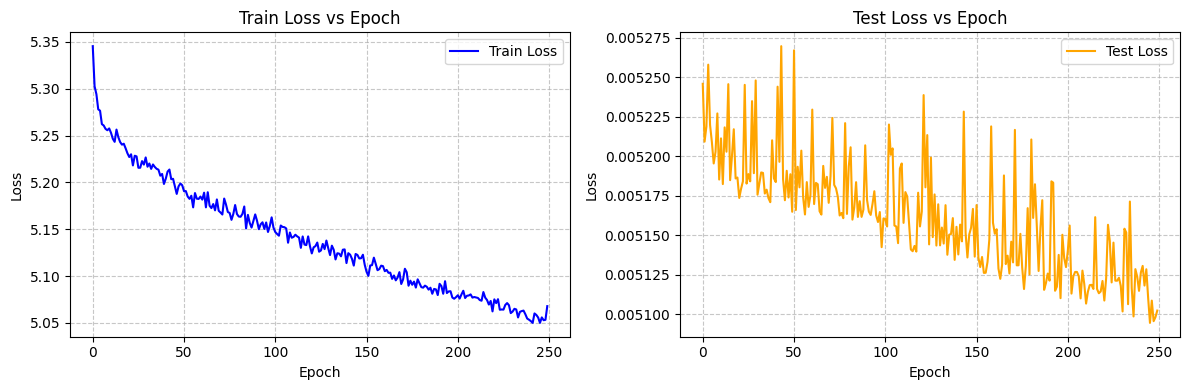

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import scipy.io as sio
import argparse
import numpy as np
import time
import matplotlib.pyplot as  plt


input_size = 192 * 2
hidden_size = [150, 200, 200 , 150]
# hidden_size = [200, 300, 300 , 200]
# hidden_size = [128, 64 , 32]
num_classes = 1
num_epochs = 250
# learning_rate = 9e-4
learning_rate = 1e-6
# learning_rate = 1e-4
learning_rate_decay = 0.999
reg = 0.001
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers = 2
patience = 100

xs_train = np.load(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_train.npy")
ys_train = np.load(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/ys_train.npy")

xs_train = xs_train.reshape(xs_train.shape[0],-1)

x_train_tensor = torch.from_numpy(xs_train).float()
y_train_tensor = torch.from_numpy(ys_train).float()
# print(ys_train[:3])
# sys.exit()

dataset = TensorDataset(x_train_tensor, y_train_tensor)

lengths = [int(len(dataset)*0.9), len(dataset)-int(len(dataset)*0.9)]

train_dataset, val_dataset = torch.utils.data.random_split(dataset, lengths)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size , 
                                           num_workers=  num_workers,
                                           drop_last= True , 
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                         batch_size=batch_size , 
                                         num_workers = num_workers)



# model_mlp = MultiLayerPerceptronWithCustomAttention(input_size, hidden_size, num_classes,4).to(device)
model_mlp = MultiLayerPerceptron_forward(input_size, hidden_size, num_classes,3).to(device)
print(count_parameters(model_mlp))

# model_mlp.apply(weights_init)
# model_mlp.load_state_dict(torch.load("/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/mlp_best_model.pt",map_location="cpu"))
model_mlp.to(device)

# Loss and optimizer
def sum_mse(yhat,y):
    return torch.sum(torch.mean((yhat - y) ** 2, dim=1))

criterion_MSE = nn.MSELoss()
criterion_MAE = nn.L1Loss()
criterion_sum_mse = sum_mse



# criterion = criterion_MAE
# criterion_train= sum_mse
# criterion_val   = nn.MSELoss()  # Standard mean MSE
criterion_train= nn.L1Loss()
criterion_val   = nn.L1Loss()  # Standard mean MSE
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)

########################################
# 5) Training loop with early stopping
########################################
best_loss = float('inf')
best_epoch = 0
epochs_no_improve = 0
lr_current = learning_rate

train_losses = []
test_losses  = []

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    # ---- Training ----
    model_mlp.train()
    running_loss = 0.0
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_mlp(features)  # shape (batch, 2)
        # labels[:,-1] *= 1000
        # labels[:,0] *= 10
        # outputs[:,-1] *= 1000
        # outputs[:,0] *= 10
        # ===================
        # labels[:,-1] *= 1000
        # outputs *= 1000
        labels[:,0] *= 1000
        outputs *= 1000
        # loss = criterion_train(outputs.squeeze(dim=1), labels[:,1])
        loss = criterion_train(outputs.squeeze(dim=1), labels[:,0])
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * features.size(0)

        # if (batch_idx + 1) % 100 == 0:
        #     print(f"Epoch [{epoch}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}],"
        #           f" Train Loss (batch): {loss.item():.4f}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ---- Validation ----
    model_mlp.eval()
    test_loss = 0.0
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            preds = model_mlp(features)
            # print(f"{preds.shape=}")
            # print(f"{labels[:,1].shape=}")
            # sys.exit()
            # test_loss += criterion_val(preds.squeeze(dim=1), labels[:,1]).item() * features.size(0)
            test_loss += criterion_val(preds.squeeze(dim=1), labels[:,0]).item() * features.size(0)
    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    # Print log
    print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}")

    # Early stopping check
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(model_mlp.state_dict(), "mlp_best_model.pt")
        print(f"New best model at epoch {epoch} with test loss {best_loss:.6f}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement for {patience} epochs. Early stopping at epoch {epoch}.")
            break

    # Update learning rate
    lr_current *= learning_rate_decay
    update_lr(optimizer, lr_current)

elapsed = time.time() - start_time
print(f"\nTraining completed in {elapsed:.2f} seconds. Best epoch: {best_epoch} with test loss {best_loss:.6f}")

# Save final model weights
torch.save(model_mlp.state_dict(), "mlp_final_model.pt")
print("Saved mlp_final_model.pt")


############################################################
# 6) Save and plot train/test losses in separate subplots
############################################################
train_losses = np.array(train_losses)
test_losses  = np.array(test_losses)

# Save them as .npy
np.save("train_losses.npy", train_losses)
np.save("test_losses.npy",  test_losses)

# Two subplots: one for Train Loss, one for Test Loss
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(train_losses, label="Train Loss", color="blue")
axs[0].set_title("Train Loss vs Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True, linestyle="--", alpha=0.7)
axs[0].legend()

axs[1].plot(test_losses, label="Test Loss", color="orange")
axs[1].set_title("Test Loss vs Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].grid(True, linestyle="--", alpha=0.7)
axs[1].legend()

plt.tight_layout()
plt.show()

# Evaluating the surrogate model

### eval for MultiLayerPerceptron_forward for cl , cd performance 

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import scipy.io as sio
import argparse
import numpy as np
import time
import matplotlib.pyplot as  plt

input_size= 192 *2
device = "cuda"
batch_size = 128
num_workers = 2

# model_mlp = MultiLayerPerceptron_forward(input_size, [200,300,300,200], 1,3).to(device)

model_mlp = MultiLayerPerceptron_forward(input_size, [150,200,200,150], 1,3)
# model_mlp = MultiLayerPerceptron_forward(input_size, [200,300,300,200], 1,3)

model_mlp.load_state_dict(torch.load("/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/Surrogate_Model_weigths/just_for_cl_150_200_200_150/mlp_best_model.pt",map_location="cpu"))
# model_mlp.load_state_dict(torch.load("/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/Surrogate_Model_weigths/just_for_cd_200_300_300_200/mlp_best_model.pt",map_location="cpu"))

model_mlp.to(device)
model_mlp.eval()
xs_test = np.load(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_test.npy")
ys_test = np.load(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/ys_test.npy")

xs_test = xs_test.reshape(xs_test.shape[0],-1)

x_test_tensor = torch.from_numpy(xs_test).float()
y_test_tensor = torch.from_numpy(ys_test).float()

model_mlp.eval()
test_loss = 0.0
dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                         batch_size=batch_size , 
                                         num_workers = num_workers)
criterion_val =  nn.MSELoss()  # Standard mean MSE
# criterion_val =  nn.L1Loss()  
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        preds = model_mlp(features)
        ans = criterion_val(preds.squeeze(dim=1), labels[:,0]).item() * features.size(0)
        test_loss += ans

print("MSE on the test loss: ",test_loss/len(test_loader.dataset))

/tmp/ipykernel_2832/3743201991.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mlp.load_state_dict(torch.load("/home/bardiya/projects/diffusion_air_manifolding/co

MSE on the test loss:  0.00010813185288239492


### eval for Hybrid_surrogate_MLP for cl , cd performance 

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import scipy.io as sio
import argparse
import numpy as np
import time
import matplotlib.pyplot as  plt

input_size= 192 *2
device = "cuda"
batch_size = 128
num_workers = 2

model_mlp = Hybrid_surrogate_MLP(input_size=192 * 2, 
                                 hidden_layers_cd_model=[200,300,300,200],
                                 hidden_layers_cl_model=[150, 200,200,150],
                                 path_cd_model=rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/Surrogate_Model_weigths/just_for_cd_200_300_300_200/mlp_best_model.pt",
                                 path_cl_model=rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/surrogate_models/Surrogate_Model_weigths/just_for_cl_150_200_200_150/mlp_best_model.pt"
                                 )
model_mlp.to(device)
model_mlp.eval()
xs_test = np.load(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_test.npy")
ys_test = np.load(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/ys_test.npy")

xs_test = xs_test.reshape(xs_test.shape[0],-1)

x_test_tensor = torch.from_numpy(xs_test).float()
y_test_tensor = torch.from_numpy(ys_test).float()

model_mlp.eval()
test_loss = 0.0
dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                         batch_size=batch_size , 
                                         num_workers = num_workers)
criterion_val =  nn.MSELoss()  # Standard mean MSE
# criterion_val =  nn.L1Loss()  
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        preds = model_mlp(features)
        ans = criterion_val(preds, labels).item() * features.size(0)
        test_loss += ans

print("MSE on the test loss:",test_loss/len(test_loader.dataset))

/tmp/ipykernel_2832/243693447.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.cl_forward_mlp.load_state_dict(torch.load(path_cl_model,map_location="cpu"))
/tmp/ipy

MSE on the test loss: 5.4146062977710516e-05


# Visualization Evaluations

In [ ]:
import os
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class AirfoilDataset(Dataset):
    """
    Loads scaled airfoil coordinates and scaled CL/CD labels,
    and can invert them back to physical units.
    """
    def __init__(self,
                 xs_scaled_path: str,
                 ys_scaled_path: str,
                 coord_min_max_path: str,
                 label_min_max_path: str):
        # load scaled arrays
        self.xs = np.load(xs_scaled_path)   # (N, 192, 2), values in [0,1]
        self.ys = np.load(ys_scaled_path)   # (N, 2), values in [0,1]

        # load min/max for coords & labels
        coord_mm = np.load(coord_min_max_path)  # [[x_min,y_min],[x_max,y_max]]
        label_mm = np.load(label_min_max_path)  # [[cl_min,cd_min],[cl_max,cd_max]]

        self.x_min,  self.y_min  = coord_mm[0]
        self.x_max,  self.y_max  = coord_mm[1]
        self.cl_min, self.cd_min = label_mm[0]
        self.cl_max, self.cd_max = label_mm[1]

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx: int):
        # scaled coords: (192,2) -> transpose to (2,192)
        coords = self.xs[idx].T.astype(np.float32)
        cl, cd = self.ys[idx].astype(np.float32)
        return torch.from_numpy(coords), torch.tensor([cl, cd], dtype=torch.float32)

    def inverse_scale_coords(self, coords_scaled: np.ndarray) -> np.ndarray:
        """
        coords_scaled: np array shape (..., 2)
        returns coords in original physical units
        """
        x_s, y_s = coords_scaled[...,0], coords_scaled[...,1]
        x = x_s * (self.x_max - self.x_min) + self.x_min
        y = y_s * (self.y_max - self.y_min) + self.y_min
        return np.stack([x, y], axis=-1)

    def inverse_scale_labels(self, ys_scaled: np.ndarray) -> np.ndarray:
        """
        ys_scaled: shape (N,2)
        returns labels in original (CL, CD) units
        """
        cl_s, cd_s = ys_scaled[:,0], ys_scaled[:,1]
        cl = cl_s * (self.cl_max - self.cl_min) + self.cl_min
        cd = cd_s * (self.cd_max - self.cd_min) + self.cd_min
        return np.stack([cl, cd], axis=-1)

    def plot_sample(self, idx: int = None):
        """
        Shows scaled vs real airfoil and label for one index.
        """
        if idx is None:
            idx = np.random.randint(len(self))
        coords_s, lbl_s = self[idx]
        # back to numpy
        coords_s = coords_s.numpy().T        # (192,2)
        lbl_s    = lbl_s.numpy()[None,:]     # (1,2)
        coords_r = self.inverse_scale_coords(coords_s[None])[0]
        lbl_r    = self.inverse_scale_labels(lbl_s)[0]

        # plot curves
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        ax[0].plot(coords_s[:,0], coords_s[:,1], label="scaled")
        ax[0].plot(coords_r[:,0], coords_r[:,1], linestyle='--', label="real")
        ax[0].set_aspect('equal')
        ax[0].set_title(f"Airfoil #{idx}")
        ax[0].legend()

        # plot labels
        cl_s_val, cd_s_val = lbl_s[0]
        cl_r_val, cd_r_val = lbl_r
        ax[1].bar(["CL","CD"], [cl_s_val, cd_s_val], alpha=0.7, label="scaled")
        ax[1].bar(["CL","CD"], [cl_r_val, cd_r_val], alpha=0.5, label="real")
        ax[1].set_title("Labels")
        ax[1].legend()

        plt.tight_layout()
        plt.show()


In [63]:
def visualize_predictions_grid_v3(model, dataset, device, sample_indices=None, set_name="Train", figsize=(20,8)):
    """
    Visualizes a grid of predictions for a set of airfoil samples.

    For each selected sample, the function plots the airfoil shape twice:
      - Top row: Annotated with the true and predicted CL values (both scaled and inverse-scaled).
      - Bottom row: Annotated with the true and predicted CL/CD ratio values (both scaled and inverse-scaled).

    Args:
      model: The trained PyTorch model.
      dataset: An instance of your AirfoilDataset.
      device: 'cuda' or 'cpu'.
      sample_indices: List or array of sample indices to visualize. If None, 5 random indices are chosen.
      set_name: String label for the dataset (e.g. "Train" or "Test").
      figsize: Tuple for figure size.
    """
    model.eval()
    if sample_indices is None:
        num_samples = 5
        sample_indices = np.random.choice(len(dataset), size=num_samples, replace=False)
    else:
        num_samples = len(sample_indices)

    # Create a grid with 2 rows and num_samples columns
    fig, axs = plt.subplots(3, num_samples, figsize=figsize)

    for j, idx in enumerate(sample_indices):
        # Get a sample from the dataset: coords (tensor of shape (2, n_points)) and scaled label (tensor of shape (2,))
        coords, label = dataset[idx]
        # Ensure coords and label are on CPU and in NumPy format
        coords_np = coords.cpu().numpy()  # shape: (2, n_points)
        temp_coords_np = coords.cpu().numpy().T  # shape: (2, n_points)

        # Run a forward pass on the sample
        coords_batch = coords.unsqueeze(0).to(device)  # add batch dimension: (1, 2, n_points)
        temp_coords_batch = torch.from_numpy(temp_coords_np).unsqueeze(0).to(device)  # add batch dimension: (1, 2, n_points)

        with torch.no_grad():
            pred = model(temp_coords_batch.reshape(coords_batch.shape[0],-1))
        pred = pred.squeeze(0).cpu()  # shape: (2,)
        # print(f"{pred=}")
        # print(f"{label=}")
        # sys.exit()

        # Inverse scale both prediction and true label
        # true_unscaled = dataset.inverse_scale_labels(torch.unsqueeze(label ,dim=0).numpy()).flatten()  # shape: (2,)
        # pred_unscaled = dataset.inverse_scale_labels(torch.unsqueeze(pred ,dim=0).numpy()).flatten()   # shape: (2,)
        true_unscaled = label
        pred_unscaled = pred

        # Extract values:
        # For CL: element 0; for ratio: element 1.
        true_CL_scaled = label[0].item()
        pred_CL_scaled = pred[0].item()
        true_ratio_scaled = label[1].item()
        pred_ratio_scaled = pred[1].item()

        true_CL_real = true_unscaled[0]
        pred_CL_real = pred_unscaled[0]
        true_ratio_real = true_unscaled[1]
        pred_ratio_real = pred_unscaled[1]

        # --- Top row: CL information ---
        axs[0, j].plot(coords_np[0], coords_np[1], 'b-', linewidth=2)
        axs[0, j].set_title(
            f"Sample {idx}\n"
            f"CL (scaled): True {true_CL_scaled:.3f}, Pred {pred_CL_scaled:.3f}\n"
            f"CL (real): True {true_CL_real:.3f}, Pred {pred_CL_real:.3f}"
        )
        axs[0, j].set_xlabel("X")
        axs[0, j].set_ylabel("Y")
        axs[0, j].set_aspect('equal', adjustable='box')
        axs[0, j].grid(True, linestyle="--", alpha=0.6)

        # --- Bottom row: CD ratio information ---
        axs[1, j].plot(coords_np[0], coords_np[1], 'b-', linewidth=2)
        axs[1, j].set_title(
            f"Sample {idx}\n"
            f"CD (scaled): True {true_ratio_scaled:.3f}, Pred {pred_ratio_scaled:.3f}\n"
            f"CD (real): True {true_ratio_real:.3f}, Pred {pred_ratio_real:.3f}"
        )
        axs[1, j].set_xlabel("X")
        axs[1, j].set_ylabel("Y")
        axs[1, j].set_aspect('equal', adjustable='box')
        axs[1, j].grid(True, linestyle="--", alpha=0.6)

        # --- Bottom row: CL/CD ratio information ---
        axs[2, j].plot(coords_np[0], coords_np[1], 'b-', linewidth=2)
        axs[2, j].set_title(
            f"Sample {idx}\n"
            f"CL/CD (scaled): True {true_CL_scaled / true_ratio_scaled:.3f}, Pred {pred_CL_scaled / pred_ratio_scaled:.3f}\n"
            f"CL/CD (real): True {true_CL_real / true_ratio_real:.3f}, Pred {pred_CL_real / pred_ratio_real:.3f}"
        )
        axs[2, j].set_xlabel("X")
        axs[2, j].set_ylabel("Y")
        axs[2, j].set_aspect('equal', adjustable='box')
        axs[2, j].grid(True, linestyle="--", alpha=0.6)

    plt.suptitle(f"{set_name} Set Predictions", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_small_subset_predictions_v3(model, dataset, device, sample_count=100, set_name="Train"):
    """
    Plots a smaller subset of samples (default=100) to compare predicted vs. true labels (CL and CL/CD).
    We do a line plot with 2 subplots:
      - Top subplot: CL (real) vs. predicted
      - Bottom subplot: Ratio (real) vs. predicted

    Args:
      model: Trained PyTorch model
      dataset: Instance of your AirfoilDataset
      device: 'cuda' or 'cpu'
      sample_count: Number of samples to plot
      set_name: String for labeling (e.g., "Train" or "Test")
    """
    model.eval()

    # Pick a random subset of sample_count indices from the dataset
    indices = np.random.choice(len(dataset), size=sample_count, replace=False)
    indices = sorted(indices)  # Sort so that the lines look smoother in the plot

    # We'll store real CL/CD and predicted CL/CD in arrays for plotting
    real_CL_vals = []
    real_CD_vals = []
    pred_CL_vals = []
    pred_CD_vals = []

    # No batch dimension here, we'll just do them one by one (100 is small enough)
    with torch.no_grad():
        for idx in indices:
            coords, scaled_label = dataset[idx]

            # coords shape: (2, n_points)
            # scaled_label shape: (2,) => [CL_scaled, ratio_scaled]
            # Move coords to device
            coords_batch = coords.unsqueeze(0).to(device)  # shape: (1, 2, n_points)
            temp_coords_batch = torch.from_numpy(coords.cpu().numpy().T).unsqueeze(0).to(device)  # shape: (1, 2, n_points)

            # Model prediction
            pred_scaled = model(temp_coords_batch.reshape(temp_coords_batch.shape[0],-1))  # shape: (1, 2)
            pred_scaled = pred_scaled.squeeze(0).cpu().numpy()  # shape: (2,)

            # Inverse-scale both the ground-truth and the prediction
            # true_unscaled = dataset.inverse_scale_labels(torch.unsqueeze(scaled_label,dim = 0).numpy()).flatten()  # shape: (2,)
            # pred_unscaled = dataset.inverse_scale_labels(np.expand_dims(pred_scaled,axis=0)).flatten()           # shape: (2,)
            true_unscaled = scaled_label  # shape: (2,)
            pred_unscaled = pred_scaled           # shape: (2,)

            # Extract CL and ratio
            real_CL_vals.append(true_unscaled[0])
            real_CD_vals.append(true_unscaled[1])
            pred_CL_vals.append(pred_unscaled[0])
            pred_CD_vals.append(pred_unscaled[1])

    # Now we have arrays of length = sample_count for real/pred CL and ratio
    x_axis = range(sample_count)  # Just 0..(sample_count-1)

    plt.figure(figsize=(12, 8))

    # --- Top subplot: CL ---
    plt.subplot(3, 1, 1)
    plt.plot(x_axis, real_CL_vals, 'o-', label="True CL", color='blue', alpha=0.7)
    plt.plot(x_axis, pred_CL_vals, 's--', label="Predicted CL", color='red', alpha=0.7)
    plt.title(f"{set_name} Set: CL on {sample_count} Samples")
    plt.xlabel("Sample Index (subset)")
    plt.ylabel("CL (real scale)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()

    # --- Bottom subplot: CD ---
    plt.subplot(3, 1, 2)
    plt.plot(x_axis, real_CD_vals, 'o-', label="True Ratio", color='blue', alpha=0.7)
    plt.plot(x_axis, pred_CD_vals, 's--', label="Predicted Ratio", color='red', alpha=0.7)
    plt.title(f"{set_name} Set: CD value on {sample_count} Samples")
    plt.xlabel("Sample Index (subset)")
    plt.ylabel("CD value (real scale)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()

    # --- Bottom subplot: CL/CD  ---
    plt.subplot(3, 1, 3)
    plt.plot(x_axis, np.array(real_CL_vals) / np.array(real_CD_vals), 'o-', label="True CL/CD", color='blue', alpha=0.7)
    plt.plot(x_axis, np.array(pred_CL_vals) / np.array(pred_CD_vals), 's--', label="Predicted CL/CD", color='red', alpha=0.7)
    plt.title(f"{set_name} Set: CL/CD value on {sample_count} Samples")
    plt.xlabel("Sample Index (subset)")
    plt.ylabel("CL/CD value (real scale)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()

    plt.tight_layout()
    plt.show()

<class '__main__.Hybrid_surrogate_MLP'>


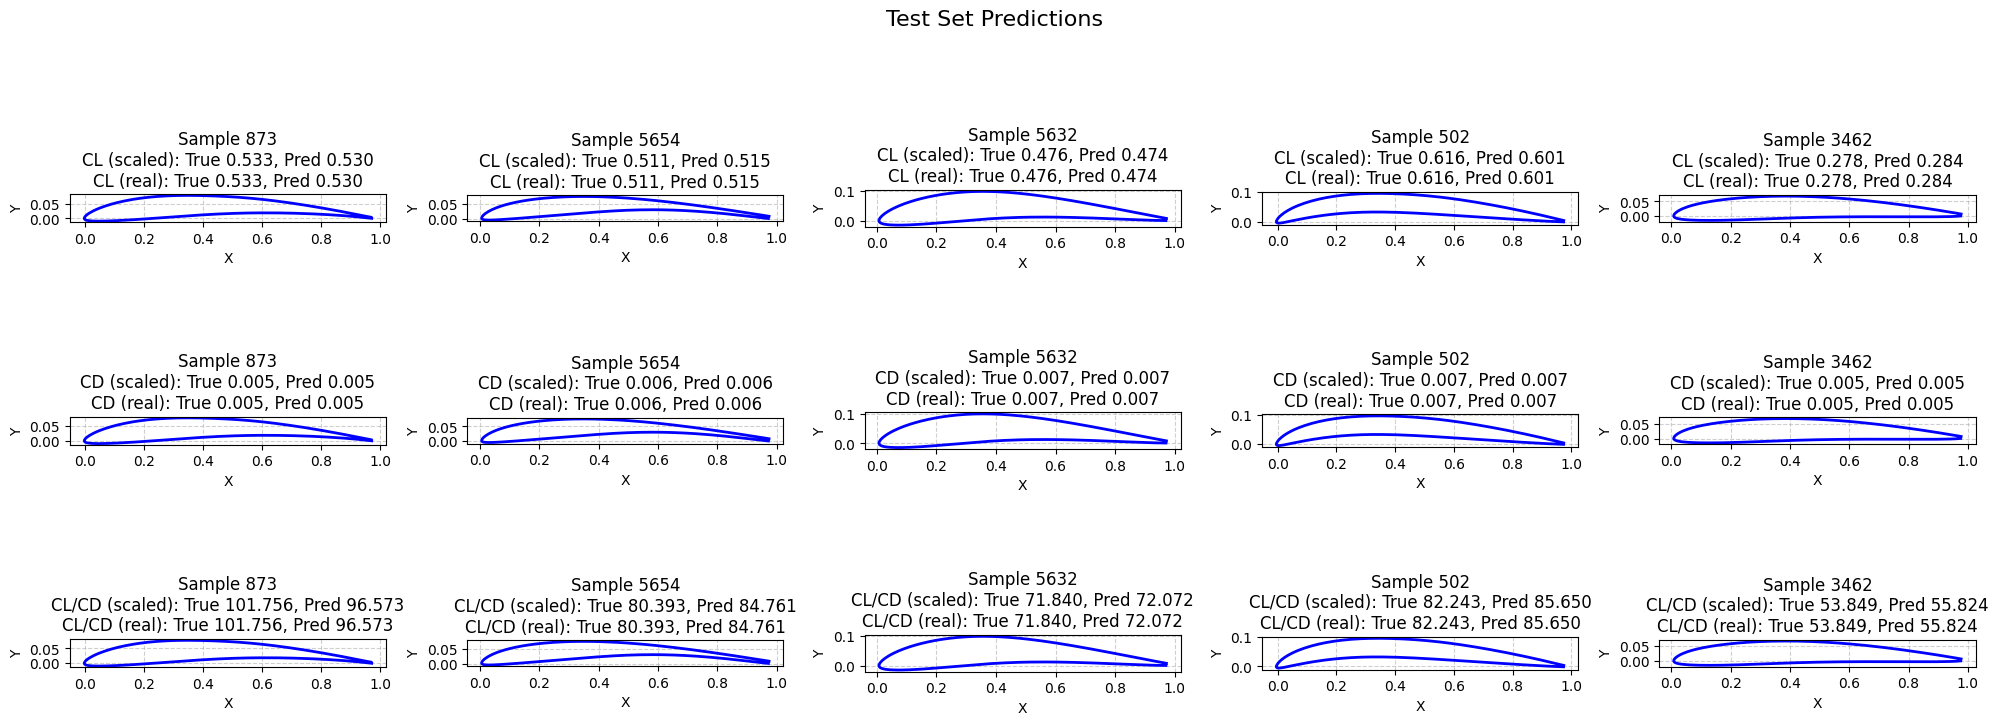

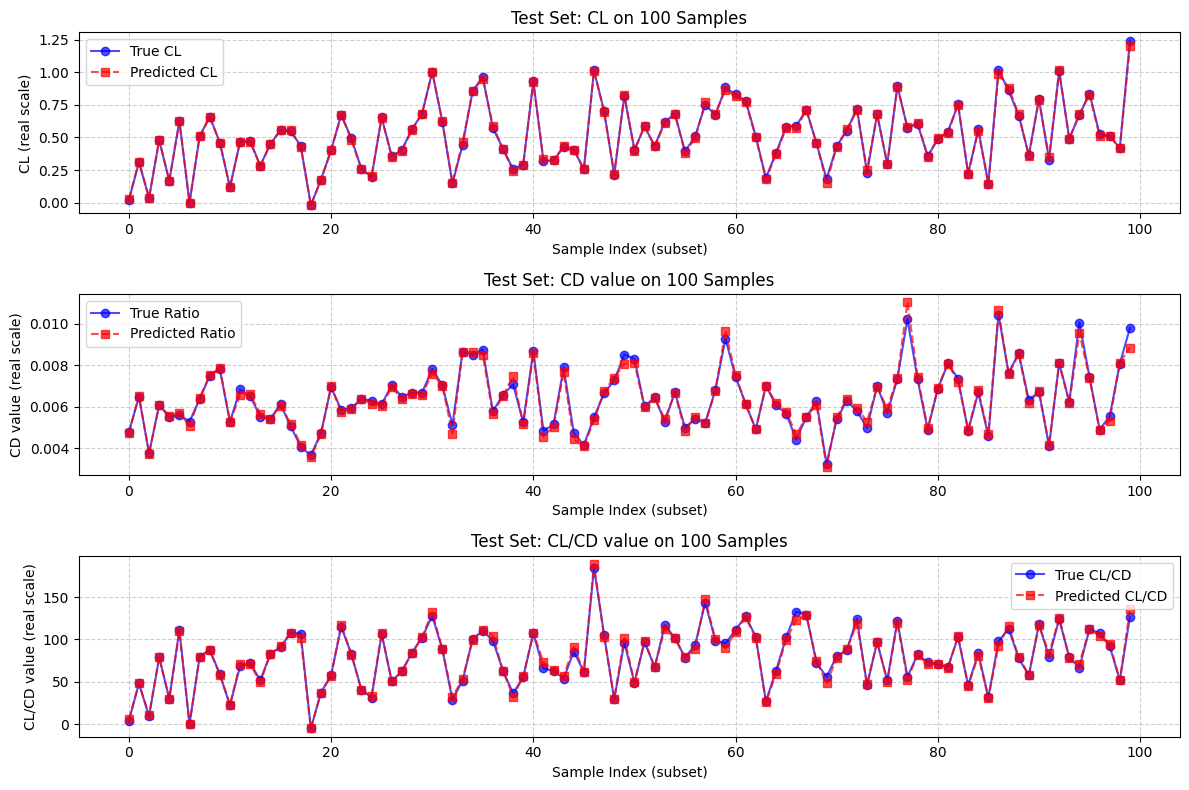

In [64]:
xs_train_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_train.npy"
xs_test_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/xs_test.npy"
ys_train_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/ys_train.npy"
ys_test_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/ys_test.npy"
coord_min_max_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/coord_min_max.npy"
label_min_max_path =  rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw/label_min_max.npy"
# train_dataset = AirfoilDataset(xs_train_path, ys_train_path, coord_min_max_path, label_min_max_path)
print(type((model_mlp)))
test_dataset = AirfoilDataset(xs_test_path, ys_test_path, coord_min_max_path, label_min_max_path)
visualize_predictions_grid_v3(model_mlp , test_dataset ,"cuda",set_name="Test")
plot_small_subset_predictions_v3(model_mlp , test_dataset ,"cuda",sample_count=100, set_name="Test")